Group name:[7] OceanWarlocks

Group number:7 

Skage Klingstedt Reistad, studentnr : 545212

Susan Desirée Bredesen Palencia, studentnr : 529305



In [1]:
%pip install xgboost
%pip install scikit-learn
%pip install pandas
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)

In [4]:
def load_bar(n, i):
    if n<=i:
        print("[====================] 100.0% complete")
        return
    progress = i / n
    bar_length = 20
    filled_length = int(progress * bar_length)

    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    percentage = (float(progress)*1000000)//100/100

    print(f'[{bar}] {percentage}% complete', end='\r')

In [5]:
RESOURCE_FOLDER="../../Project materials(1)"
#PUT IN PATH TO THE FOLDER CONTAINING TRAINING DATA HERE

In [6]:
class CSVParser():

    def __init__(
        self, folderpath: str = RESOURCE_FOLDER
    ):
        self.folderpath = folderpath

    def parse_time(self,raw_time):
        try:
            date_format = "%m-%d %H:%M"
            parsed_datetime = datetime.strptime(raw_time, date_format)

            return parsed_datetime.replace(year = 2024)
        
        except ValueError:
            return None

    def retrieve_ais(self,path):
        df_ais = pd.read_csv(path, sep='|')
        df_ais['time'] = pd.to_datetime(df_ais['time'])
        df_ais['etaParsed'] = df_ais['etaRaw'].apply(self.parse_time)
        df_ais=df_ais.drop(['etaRaw'], axis = 1)
        return df_ais
    
    def retrieve_tests(self,path):
        df_tests = pd.read_csv(path, sep=',')
        df_tests["time"] = pd.to_datetime(df_tests["time"])
        return df_tests

    def retrieve_ports(self,path):
        df_ports = pd.read_csv(path, sep='|')
        df_ports['portLongitude'] = df_ports['longitude']
        df_ports['portLatitude'] = df_ports['latitude']
        df_ports=df_ports.drop(['name', 'portLocation', 'countryName', 'longitude', 'latitude'], axis = 1)
        return df_ports

    def retrieve_training_data(self):
        df_ais=self.retrieve_ais(self.folderpath+'/ais_train.csv')
        df_ports=self.retrieve_ports(self.folderpath+'/ports.csv')

        result = df_ais
        result = pd.merge(df_ais, df_ports, on='portId')

        return result

    def retrieve_test_data(self):
        df_ais=self.retrieve_tests(self.folderpath+'/ais_test.csv')
        
        result = df_ais
        
        return result

    

In [7]:
parser = CSVParser(RESOURCE_FOLDER)

In [8]:
total_df = parser.retrieve_training_data()

In [9]:
total_df["time"] = pd.to_datetime(total_df['time'])

In [ ]:
def calculate_time_diffs_within_window(df, time_deltas=[]):
    df["tempId"]=[i for i in range(len(df))]
    srt_cls= ["vesselId", "time", "latitude", "longitude", "tempId"]
    feat_cls=[col for col in df.columns if col not in srt_cls]
    feat_cls.append("tempId")
    sort_cut_df = df[srt_cls]
    feat_cut_df = df[feat_cls]
    result_list= []
    vessel_dfs = sort_cut_df.groupby('vesselId')
    j=0
    for _, vessel_df in vessel_dfs:
        j+=1
        load_bar(len(vessel_dfs), j)
        
        vessel_df = vessel_df.sort_values(by='time')
        groups = vessel_df.groupby(pd.Grouper(key="time", freq='5D'))
        
        for _, group in groups:
                group_deltas=time_deltas.copy()
                if len(group) < 2:
                    continue
                while group_deltas and group.iloc[-1]['time']-group.iloc[0]['time'] < group_deltas[0]:
                    group_deltas.pop(0)
                feature_rows=[group.iloc[0]]

                for i in range(len(group)):
                    future_row = group.iloc[i]

                    for current_row in feature_rows:
                        new_row = current_row.copy()
                        new_row['next_latitude'] = future_row['latitude']
                        new_row['next_longitude'] = future_row['longitude']
                        new_row['time_diff'] = (future_row['time'] - current_row['time']).total_seconds()
                        result_list.append(new_row)

                    if group_deltas:
                        if group.iloc[-1]['time']-future_row['time'] < group_deltas[0]:
                            group_deltas.pop(0)
                            feature_rows.append(future_row)
                        
    print("Concating")
    result_df = pd.DataFrame(result_list)


    last_rows = df.groupby('vesselId').tail(1)

    last_rows = last_rows.reset_index(drop=True)
    
    print("Merging")
    result_df = pd.merge(result_df, feat_cut_df, on='tempId')

    result_df=result_df.drop(['tempId'], axis = 1)

    return result_df, last_rows

In [11]:
timedeltas=[timedelta(days=3),timedelta(days=1)]

In [12]:
#This function is memory heavy, it has a tendency t
total_df, last_rows = calculate_time_diffs_within_window(total_df, timedeltas) 

[====================] 100.0% complete
Concating
Merging


In [13]:
class FeatureEngineer:
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def add_feature(self, func, *args, **kwargs):
        """
        Apply a function to the dataframe to add a new feature.
        
        Parameters:
        func (callable): A function that takes a dataframe and returns a series.
        *args: Additional positional arguments to pass to the function.
        **kwargs: Additional keyword arguments to pass to the function.
        """
        new_df = func(self.df, *args, **kwargs)
        if new_df is None:
            return
        if len(new_df) == len(self.df):
            self.df=new_df

    def get_dataframe(self):
        return self.df
    
    def apply_features(self, features):
        """
        Apply a list of functions to the dataframe to add new features.
        
        Parameters:
        features (list): A list of functions that take a dataframe and return a series.
        """
        for func in features:
            print(f"Applying {func.__name__}")
            self.add_feature(func)

In [14]:
def numerize_UN_LOCODE(total_df):
    if "UN_LOCODE" not in total_df.columns:
        return None

    unique_values = total_df["UN_LOCODE"].unique()
    unique_values_dict = {value: i for i, value in enumerate(unique_values)}
    
    return_values = total_df["UN_LOCODE"].map(unique_values_dict)
    total_df = total_df.drop(columns = "UN_LOCODE")
    total_df["UN_LOCODE_num"] = return_values

    return total_df

    

def numerize_ISO(total_df):
    if "ISO" not in total_df.columns:
        return None

    unique_values = total_df["ISO"].unique()
    unique_values_dict = {value: i for i, value in enumerate(unique_values)}
    
    return_values = total_df["ISO"].map(unique_values_dict)
    
    total_df = total_df.drop(columns = "ISO")
    total_df["ISO_num"] = return_values
    return total_df


In [15]:
feature_engineering_functions = [ 
                                 numerize_UN_LOCODE, 
                                 numerize_ISO
                                 ] 



feature_engineer = FeatureEngineer(total_df)
feature_engineer.apply_features(feature_engineering_functions)
total_df = feature_engineer.get_dataframe()
total_df.set_index("time", inplace=True)

Applying numerize_UN_LOCODE
Applying numerize_ISO


In [16]:
def replace_nan_with_zero(df):
    for col in df.columns:
        if df[col].isna().any():
            non_na_values = df[col].dropna()
            if non_na_values.apply(lambda x: isinstance(x, (bool, int, float))).all():
                df[col].fillna(0, inplace=True)
    return df

total_df = replace_nan_with_zero(total_df)

In [17]:

def remove_non_numeric_columns(df):
    df = df.select_dtypes(include=['bool', 'float', 'int'])
    return df

total_df = remove_non_numeric_columns(total_df)


In [18]:
def train_test_split(df_old, perc1, perc2):

    df = df_old.sample(frac=1).reset_index(drop=True)

    y_list = ['next_latitude', 'next_longitude']
    ys = df[y_list]
    Xs = df.drop(columns = y_list)

    X_train = Xs.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    y_train = ys.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    X_val = Xs.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    y_val = ys.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    X_test = Xs.iloc[int(np.round(Xs.shape[0]*perc2)):,:]
    y_test = ys.iloc[int(np.round(Xs.shape[0]*perc2)):,:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(total_df, 0.85, 0.95)

In [20]:
X_train_cols= X_train.columns

In [21]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest_X = xgb.DMatrix(X_test)

params = {"objective": "reg:squarederror",
            "max_depth": 10,
            "booster": "gbtree",
            "tree-method": "gpu_hist",
            "colsample_bynode": 0.5,
            "num_parallel_tree": 30,
            "subsample": 0.7,
            "seed": 42,
            "random_state": 42,
            "learning_rate": 1,
            "verbosity": 1
            }

num_boost_round = 30



early_stopping_rounds = 3

print(dtrain)

model = xgb.train(params, dtrain, num_boost_round, evals=[(dval, "validation")], 
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=True)


preds = model.predict(dtest_X)

[0]	validation-rmse:3.05850
[1]	validation-rmse:2.59256
[2]	validation-rmse:2.43883
[3]	validation-rmse:2.33850
[4]	validation-rmse:2.23417
[5]	validation-rmse:2.14695
[6]	validation-rmse:2.05737
[7]	validation-rmse:1.99761
[8]	validation-rmse:1.93475
[9]	validation-rmse:1.86966
[10]	validation-rmse:1.80780
[11]	validation-rmse:1.75599
[12]	validation-rmse:1.71307
[13]	validation-rmse:1.66847
[14]	validation-rmse:1.62756
[15]	validation-rmse:1.58378
[16]	validation-rmse:1.54925
[17]	validation-rmse:1.51380
[18]	validation-rmse:1.48024
[19]	validation-rmse:1.44772
[20]	validation-rmse:1.41462
[21]	validation-rmse:1.38781
[22]	validation-rmse:1.36379
[23]	validation-rmse:1.34268
[24]	validation-rmse:1.31803
[25]	validation-rmse:1.29559
[26]	validation-rmse:1.27290
[27]	validation-rmse:1.25112
[28]	validation-rmse:1.22903
[29]	validation-rmse:1.21016


In [22]:
def calculate_time_diff_with_last_rows(test_df, last_rows):
    
    merged_df = pd.merge(
        test_df[["ID", "vesselId", "time"]],
        last_rows,
        on='vesselId',
        suffixes=('', '_last')
    )
    print(merged_df.columns)
    
    merged_df['time_diff'] = (merged_df['time'] - merged_df['time_last']).dt.total_seconds()
    
    merged_df = merged_df.drop(columns=[ 'time_last'])
    
    
    return merged_df

In [23]:
test_df = parser.retrieve_test_data()

In [24]:
def split_dataframe(df):
    df['ID'] = range(1, len(df) + 1)
    df_predicted = df[['ID', 'latitude', 'longitude']].rename(columns={'latitude': 'predicted_latitude', 'longitude': 'predicted_longitude'})
    df_info = df[['ID', 'time', 'vesselId']]
    
    return df_predicted, df_info

In [25]:
test_df=calculate_time_diff_with_last_rows(test_df,last_rows)

Index(['ID', 'vesselId', 'time', 'time_last', 'cog', 'sog', 'rot', 'heading',
       'navstat', 'latitude', 'longitude', 'portId', 'etaParsed', 'UN_LOCODE',
       'ISO', 'portLongitude', 'portLatitude'],
      dtype='object')


In [26]:
feature_engineer = FeatureEngineer(test_df)
feature_engineer.apply_features(feature_engineering_functions)
test_df = feature_engineer.get_dataframe()

test_df.set_index("time", inplace=True)
test_df = remove_non_numeric_columns(test_df)





Applying numerize_UN_LOCODE
Applying numerize_ISO


In [27]:
def make_predictions(model, input_df):
    # Extract the features for prediction, excluding the 'ID' column
    features_df = input_df.drop(columns=['ID'])
    features_df = features_df[X_train_cols]
    # Generate predictions using the model
    predictions = model.predict(xgb.DMatrix(features_df))
    
    # Create a DataFrame with the predictions, renaming columns as required
    predictions_df = pd.DataFrame(predictions, columns=['next_latitude', 'next_longitude'])
    predictions_df = predictions_df.rename(columns={'next_latitude': 'latitude', 'next_longitude': 'longitude'})
    
    # Combine the 'ID' column with the predictions DataFrame
    result_df = pd.concat([input_df['ID'].reset_index(drop=True), predictions_df], axis=1)
    
    return result_df

In [28]:
result_df = make_predictions(model, test_df)
result_fin = pd.DataFrame()
result_fin[["ID","longitude_predicted","latitude_predicted"]]=result_df[["ID","longitude","latitude"]]

In [29]:
result_fin.to_csv(RESOURCE_FOLDER+"/result_simple.csv", index=False)

In [31]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.6519620694424753
MSE: 1.2275585699329405
RMSE: 1.1079524222334372
R² Score: 0.9990924885319941


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

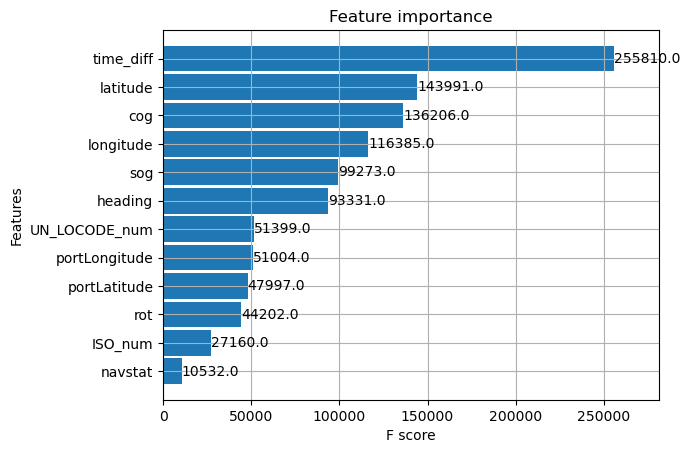

In [32]:
plot_importance(model, height=0.9)